In [37]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

In [20]:
url = "https://raw.githubusercontent.com/AHMerrill/unstructured-data-2/main/reviews_final.csv"
reviews = pd.read_csv(url)
display(reviews.head())
display(reviews.shape)

,beer,brewery,style,style_id,average_user_rating,username,user_rating,delta_from_average,look,smell,taste,feel,overall,date,review_text,brewery_id,beer_id,page_start
0,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,MadMadMike,4.53,0.07,4.25,4.25,4.75,4.50,4.50,"Jul 29, 2025","In bottle, on tap, at the brewery - anywhere t...",17981,98020,0
1,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Rug,4.06,-0.40,4.00,4.25,4.00,4.00,4.00,"Jul 01, 2022",Unknown vintage\n\nSome more BIF heat from the...,17981,98020,0
2,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,BFCarr,4.43,-0.03,4.25,4.25,4.50,4.50,4.50,"Apr 02, 2021",Pours dark brown with a thin tan head. Aroma c...,17981,98020,0
3,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Dfeinman1,4.23,-0.23,4.00,4.75,4.00,4.00,4.25,"Mar 02, 2021",Such a tasty beer. Perfect mouthfeel and carbo...,17981,98020,0
4,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Radome,4.54,0.08,4.75,4.50,4.50,4.75,4.50,"Jan 02, 2021",Poured from a bomber bottle into a Duvel glass...,17981,98020,0


(17863, 18)

## We used TF-IDF to get the top words.  TF-IDF is still BoW (in the sense that it's orderless), just down-weighting words that appear everywhere.  We used TF-IDF only to pick out attributes.  Later we'll switch to count-vectorizer.

In [21]:
# Use scikit-learn’s TfidfVectorizer
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",    # basic English stopwords only
    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b",  # only words with ≥3 letters
    max_df=0.8,              # ignore terms in >80% of docs (too common)
    min_df=5,                # keep only words that appear in ≥5 reviews
    max_features=10000        # limit vocabulary size
)

X_tfidf = vectorizer.fit_transform(reviews["review_text"].astype(str))

print("Shape:", X_tfidf.shape)

Shape: (17863, 7011)


In [30]:
# Average TF-IDF across all reviews
avg_tfidf = X_tfidf.mean(axis=0).A1
vocab = vectorizer.get_feature_names_out()

top_idx = np.argsort(avg_tfidf)[::-1][:500]
top_words = [(vocab[i], avg_tfidf[i]) for i in top_idx]

## Then we pasted the top 500 words into chatGPT and asked it to pick out an attribute list

In [23]:
# ==================================================
# Master list of attribute keywords mined from corpus
# ==================================================
ATTRIBUTES = [
    # Hop-forward / bitter
    "hoppy", "hops", "bitter", "bitterness", "dank", "pine", "piney", "resin", "resinous", "floral",

    # Citrus & fruit
    "citrus", "grapefruit", "orange", "lemon", "tangerine", "mango", "pineapple", "peach",
    "tropical", "juicy", "citrusy", "apricot", "papaya", "guava",

    # Roast / cocoa / coffee
    "roasted", "roasty", "roast", "coffee", "espresso", "chocolate", "cocoa", "mocha",

    # Caramel / dessert-like
    "vanilla", "caramel", "toffee", "maple", "molasses", "fudge", "dessert", "candied",

    # Sour / tart / funk
    "sour", "tart", "tartness", "acidity", "acidic", "funky", "barnyard", "lambic",

    # Body / mouthfeel
    "smooth", "creamy", "silky", "velvety", "chewy", "oily", "sticky", "viscous", "dense",

    # Crisp / refreshing
    "crisp", "dry", "refreshing", "clean", "bright",

    # Spice / herbal
    "spicy", "pepper", "cinnamon", "herbal",

    # Strength / heat
    "strong", "boozy", "warming", "warmth",

    # Appearance
    "hazy", "cloudy", "clear"
]


## We then collapsed / mapped some of our attributes so that users input is more regularized

In [25]:
# =====================================
# Canonical attribute mapping dictionary
# =====================================

ATTR_MAP = {
    # Hop-forward / bitter
    "hoppy": "hoppy",
    "hops": "hoppy",
    "bitter": "bitter",
    "bitterness": "bitter",
    "dank": "dank",
    "pine": "pine",
    "piney": "pine",
    "resin": "resin",
    "resinous": "resin",
    "floral": "floral",

    # Citrus & fruit
    "citrus": "citrus",
    "citrusy": "citrus",
    "grapefruit": "grapefruit",
    "orange": "orange",
    "lemon": "lemon",
    "tangerine": "tangerine",
    "mango": "mango",
    "pineapple": "pineapple",
    "peach": "peach",
    "tropical": "tropical",
    "juicy": "juicy",
    "apricot": "apricot",
    "papaya": "papaya",
    "guava": "guava",

    # Roast / cocoa / coffee
    "roast": "roasty",
    "roasted": "roasty",
    "roasty": "roasty",
    "coffee": "coffee",
    "espresso": "coffee",
    "chocolate": "chocolate",
    "cocoa": "chocolate",
    "mocha": "chocolate",

    # Caramel / dessert-like
    "vanilla": "vanilla",
    "caramel": "caramel",
    "toffee": "toffee",
    "maple": "maple",
    "molasses": "molasses",
    "fudge": "fudge",
    "dessert": "dessert",
    "candied": "candied",

    # Sour / tart / funk
    "sour": "sour",
    "tart": "sour",
    "tartness": "sour",
    "acidity": "sour",
    "acidic": "sour",
    "funky": "funky",
    "barnyard": "funky",
    "lambic": "lambic",

    # Body / mouthfeel
    "smooth": "smooth",
    "creamy": "creamy",
    "silky": "silky",
    "velvety": "velvety",
    "chewy": "chewy",
    "oily": "oily",
    "sticky": "sticky",
    "viscous": "viscous",
    "dense": "dense",

    # Crisp / refreshing
    "crisp": "crisp",
    "dry": "dry",
    "refreshing": "refreshing",
    "clean": "clean",
    "bright": "bright",

    # Spice / herbal
    "spicy": "spicy",
    "pepper": "pepper",
    "cinnamon": "cinnamon",
    "herbal": "herbal",

    # Strength / heat
    "strong": "strong",
    "boozy": "boozy",
    "warming": "warm",
    "warmth": "warm",

    # Appearance
    "hazy": "hazy",
    "cloudy": "cloudy",
    "clear": "clear"
}


## Also created some expansions.  This way, if a user types "citrus," it also expands the search into various types of citrus, so the search will be more robust accross the reviews

## Then the user inputs their preferences

In [26]:
# ==============================
# Customer preferences (edit me)
# ==============================
def normalize_attribute(token: str) -> str:
    return ATTR_MAP.get(token.lower(), token.lower())

# Example for customer input
CUSTOMER_ATTRIBUTES = ["Hops", "CRISP", "citrusy"]
CUSTOMER_ATTRIBUTES = [normalize_attribute(a) for a in CUSTOMER_ATTRIBUTES]
print(CUSTOMER_ATTRIBUTES)
# ['hoppy', 'crisp', 'citrus']

# Example for reviews (tokenize then normalize)
# review_tokens = review_text.split()
# normalized_tokens = [normalize_attribute(t) for t in review_tokens]


['hoppy', 'crisp', 'citrus']


## We also normalized the review_text field so that the words there will better match the user input normalization

In [35]:
import re

def normalize_attribute(token: str) -> str:
    return ATTR_MAP.get(token.lower(), token.lower())

def normalize_review(text: str) -> str:
    """
    1. Lowercase
    2. Tokenize on spaces (you can get fancier later if needed)
    3. Replace tokens using ATTR_MAP if present
    4. Rejoin into normalized review text
    """
    if not isinstance(text, str):
        return ""
    tokens = re.findall(r"[a-zA-Z]+", text.lower())  # keep only words
    norm_tokens = [normalize_attribute(t) for t in tokens]
    return " ".join(norm_tokens)

# Create a normalized text column just for vectorization
reviews["review_norm"] = reviews["review_text"].apply(normalize_review)

# Check a few before/after
for i in range(3):
    print("RAW:", reviews["review_text"].iloc[i][:120])
    print("NORM:", reviews["review_norm"].iloc[i][:120])
    print("---")


RAW: In bottle, on tap, at the brewery - anywhere this classic gem shows up, got to get a pull. High quality stuff right here
NORM: in bottle on tap at the brewery anywhere this classic gem shows up got to get a pull high quality stuff right here the c
---
RAW: Unknown vintage

Some more BIF heat from the legendary @Eziel! I’m starting to work my way up to the more acclaimed bott
NORM: unknown vintage some more bif heat from the legendary eziel i m starting to work my way up to the more acclaimed bottles
---
RAW: Pours dark brown with a thin tan head. Aroma certainly coffee and some booze notes. Taste is mostly booze (whiskey/bourb
NORM: pours dark brown with a thin tan head aroma certainly coffee and some booze notes taste is mostly booze whiskey bourbon 
---


## For the recommender, we switched to count-vectorizer.  That way each word is represented as a vector of word counts, averaged at the beer level.  That count-vector is then compared to the user's attribute vector with cosine similarity

## We then used VADER for sentiment analysis.  It's built into nltk and was constructed from social media & review-style data, so it should do ok with slang and intensifiers like "super-hoppy"

## VADER will produce a sentiment score, and then that is used with SENTIMENT_WEIGHT to produce a final score

## In that way, cosine similarity is combined with sentiment to get a final score (i.e. user attributes will not be matched to a beer that has poor sentiment)

## $$
\text{final}
= \text{cosine} \times \left((1-w) + w \cdot \frac{\text{sentiment} + 1}{2}\right)
$$



In [34]:
# ===============================================================
# Recommender (Count BoW) + Cosine + VADER sentiment
# Assumes you already have:
#   reviews["review_norm"]   (normalized with ATTR_MAP)
#   CUSTOMER_ATTRIBUTES      (normalized list, e.g., ["citrus","hoppy","crisp"])
#   columns: beer, brewery, style, average_user_rating
# ===============================================================

# --- knobs you can tweak ---
USE_BINARY = False        # False = counts (intensity matters), True = presence/absence
SENTIMENT_WEIGHT = 0.5    # 0..1; multiplicative boost for sentiment (0 = ignore sentiment)

# 1) Build a BoW on just your canonical attribute tokens (clean & interpretable)
canonical_vocab = sorted(set(ATTR_MAP.values()))
vectorizer = CountVectorizer(vocabulary=canonical_vocab, binary=USE_BINARY)

# 2) Vectorize normalized reviews (review x vocab)
X_bow = vectorizer.transform(reviews["review_norm"].astype(str))

# 3) Collapse to BEER-level centroids (mean to avoid popularity bias)
grp = reviews.groupby("beer", sort=False).indices               # dict: beer -> row indices
beer_keys = list(grp.keys())
beer_mat = np.vstack([X_bow[idxs].mean(axis=0).A1 for idxs in grp.values()])  # (n_beers x |vocab|)

# 4) Turn the user's 3 attributes into a query vector in the same space
query_doc = " ".join(CUSTOMER_ATTRIBUTES)   # e.g., "citrus hoppy crisp"
qvec = vectorizer.transform([query_doc])    # (1 x |vocab|)
cosine_scores = cosine_similarity(beer_mat, qvec).ravel()

# 5) Sentiment: VADER per review → mean per beer (compute once, reuse later)
if "_sentiment" not in reviews.columns:
    try:
        _ = SentimentIntensityAnalyzer()
    except:
        nltk.download("vader_lexicon", quiet=True)
    sia = SentimentIntensityAnalyzer()
    reviews["_sentiment"] = reviews["review_norm"].map(lambda t: sia.polarity_scores(t)["compound"])

beer_sent = reviews.groupby("beer")["_sentiment"].mean().reindex(beer_keys).values
sent_pos = (beer_sent + 1.0) / 2.0  # map [-1,1] → [0,1]

# Blend: final = cosine * ((1 - w) + w * sent_pos)
final_score = cosine_scores * ((1 - SENTIMENT_WEIGHT) + SENTIMENT_WEIGHT * sent_pos)

# 6) Results table: Top 3 + next 20, with diagnostics
meta = (reviews
        .groupby("beer")[["brewery","style","average_user_rating"]]
        .first()
        .reset_index())

results = (pd.DataFrame({
            "beer": beer_keys,
            "cosine": cosine_scores,
            "sentiment_mean": beer_sent,
            "final_score": final_score
          })
          .merge(meta, on="beer", how="left")
          .sort_values("final_score", ascending=False)
          .reset_index(drop=True))

# Count how many attribute dimensions are actually present in each beer centroid
attr_dims_nonzero = (beer_mat > 0).sum(axis=1)
results["attr_dims_nonzero"] = attr_dims_nonzero

# Rank + show Top 3 and the next 20 contenders (total 23)
results["rank"] = np.arange(1, len(results) + 1)
display_cols = ["rank","beer","brewery","style",
                "final_score","cosine","sentiment_mean",
                "attr_dims_nonzero","average_user_rating"]
top_table = results.head(23)[display_cols]
top_table


,rank,beer,brewery,style,final_score,cosine,sentiment_mean,attr_dims_nonzero,average_user_rating
0,1,Zombie Dust,3 Floyds Brewing Co.,Russian Imperial Stout,0.543370,0.596120,0.646048,30,4.57
1,2,Citra,Kern River Brewing Company,Imperial IPA,0.492471,0.532671,0.698127,29,4.55
2,3,Pliny The Younger,Russian River Brewing Company,Imperial IPA,0.485461,0.527109,0.683951,26,4.69
3,4,Bodhi,Columbus Brewing Company,Imperial IPA,0.467664,0.498054,0.755934,31,4.46
4,5,Hopslam Ale,Bell's Brewery - Eccentric Café & General Store,Russian Imperial Stout,0.455493,0.493079,0.695097,33,4.45
5,6,Emerald Grouper,Pipeworks Brewing Co.,Imperial IPA,0.450099,0.478097,0.765752,17,4.46
6,7,Pseudo Sue,Toppling Goliath Brewing Company,American Pale Ale,0.446723,0.482834,0.700837,27,4.49
7,8,Abner,Hill Farmstead Brewery,Saison,0.445018,0.484135,0.676809,29,4.63
8,9,Pseudo Sue - Double Dry-Hopped,Toppling Goliath Brewing Company,American Pale Ale,0.440196,0.475222,0.705178,32,4.52
9,10,Dorothy (Wine Barrel Aged),Hill Farmstead Brewery,Saison,0.436326,0.459855,0.795338,35,4.53


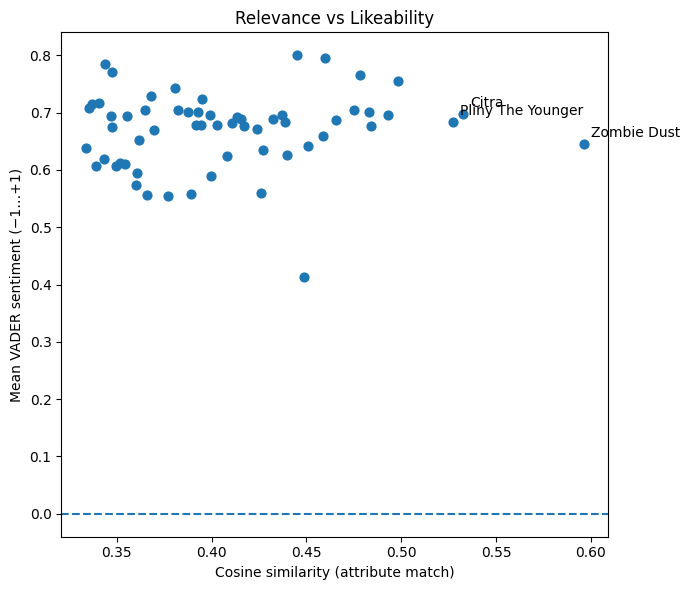

In [38]:
topN = results.head(60).copy()  # wider view
plt.figure(figsize=(7,6))
plt.scatter(topN["cosine"], topN["sentiment_mean"], s=40)

# annotate top 3
for _, r in results.head(3).iterrows():
    plt.annotate(r["beer"], (r["cosine"], r["sentiment_mean"]), xytext=(5,5), textcoords="offset points")

plt.axhline(0, linestyle="--")  # sentiment 0 line
plt.xlabel("Cosine similarity (attribute match)")
plt.ylabel("Mean VADER sentiment (−1…+1)")
plt.title("Relevance vs Likeability")
plt.tight_layout()
plt.show()
